<a href="https://colab.research.google.com/github/teodorachiriac73/PMP-2024/blob/main/ExamenColab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
x=5
print(x)

5


     Varsta  Sex  Educatie  Venit  Vot
0        45    1         0   8.06    1
1        39    1         1   6.48    1
2        46    1         1   5.48    1
3        55    0         0   5.61    1
4        38    1         1   5.86    1
..      ...  ...       ...    ...  ...
495      45    0         2   8.30    1
496      30    0         1   3.97    0
497      38    0         1   6.12    1
498      31    1         2   6.86    1
499      26    0         2   7.39    1

[500 rows x 5 columns]
Dimensiunea lui X_normalized: (500, 4)


Output()

Output()

array([<Axes: title={'center': 'beta\n0'}>,
       <Axes: title={'center': 'beta\n1'}>,
       <Axes: title={'center': 'beta\n2'}>,
       <Axes: title={'center': 'beta\n3'}>], dtype=object)

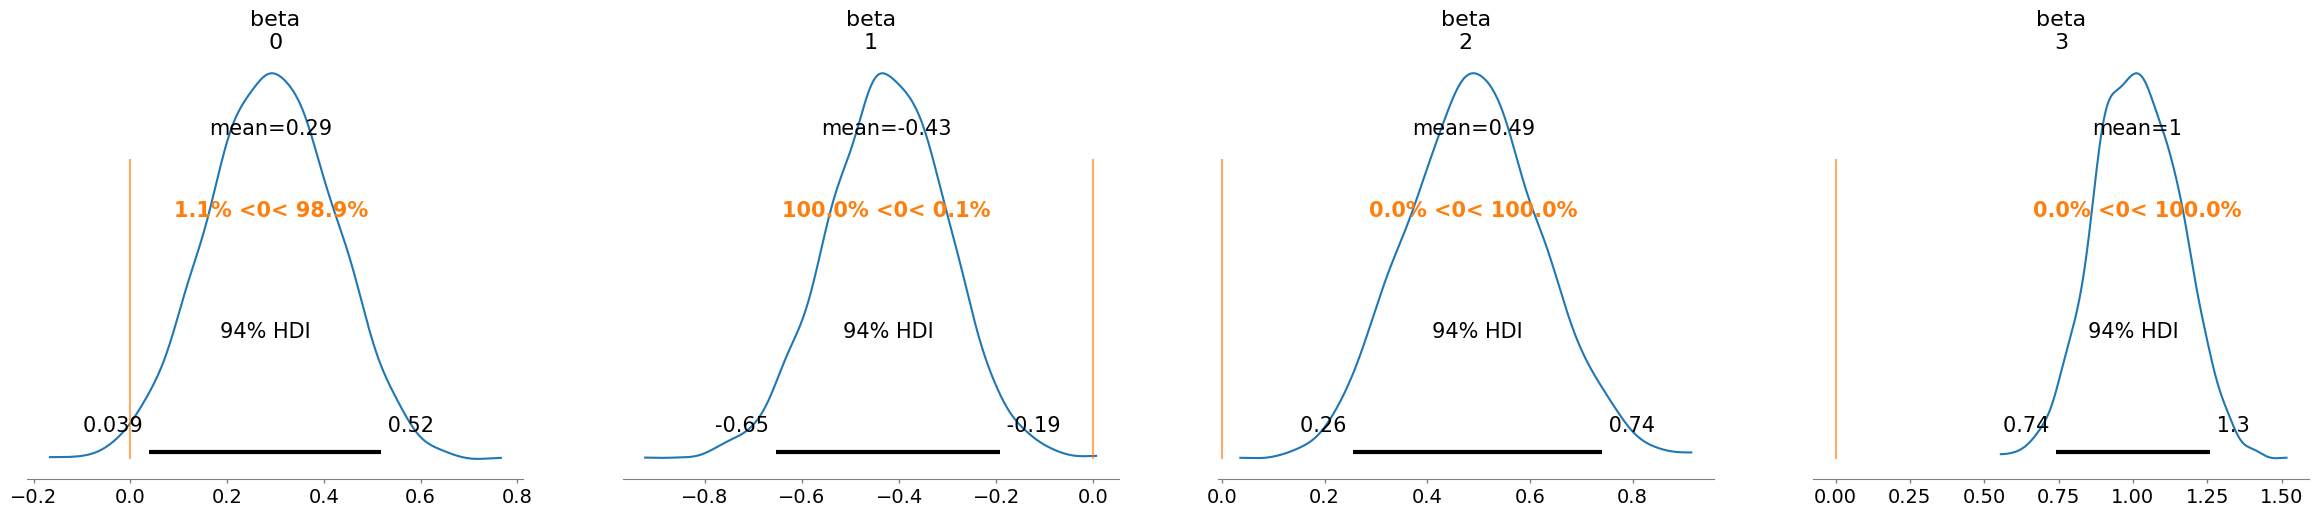

In [65]:
import pymc as pm
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from arviz import waic, loo

#a - prezicere variabila dependenta
data = pd.read_csv("date_alegeri_turul2.csv")
print(data)

X = data[['Varsta', 'Sex','Educatie', 'Venit']]  #variabilele independente
y = data['Vot'] # variabila dependenta

# vom normaliza datele
X_normalized = (X - X.mean()) / X.std()
print("Dimensiunea lui X_normalized:", X_normalized.shape)

with pm.Model() as full_model:
    # priori pentru coeficienti
    beta = pm.Normal("beta", mu=0, sigma=10, shape=X_normalized.shape[1])
    intercept = pm.Normal("intercept", mu=0, sigma=10)
    # regresia logistica
    logits = pm.math.dot(X_normalized, beta) + intercept
    p = pm.Deterministic("p", pm.math.sigmoid(logits))

    # observatiile despre vot
    y_obs = pm.Bernoulli("y_obs", p=p, observed=y)

    full_trace = pm.sample(1000, tune=1000, return_inferencedata=True)

pm.plot_posterior(full_trace, var_names=["beta"], ref_val=0)



In [45]:
print(y.value_counts())
#clasele nu par bine balansate

Vot
1    396
0    104
Name: count, dtype: int64


In [66]:
with full_model:
    posterior_predictive = pm.sample_posterior_predictive(full_trace, var_names=["p"])

print(posterior_predictive)
# extragem probabilitatile medii din esantioane
p = posterior_predictive["observed_data"]["y_obs"]

# convertim probabilitatile in clasa 0 sau 1
predicted_votes = (p > 0.5).astype(int)

print(predicted_votes)

Output()

Inference data with groups:
	> posterior_predictive
	> observed_data
<xarray.DataArray 'y_obs' (y_obs_dim_0: 500)> Size: 4kB
array([1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1,
       0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1,

Observam ca beta 3 are cea mai mare medie, deci indica o variabila care influenteaza foarte mult rezultatul.
A doua cea mai mare este pentru beta 2.

In [69]:
important_vars = [2, 3]  #indicii variabilelor relev


#c
# modelul cu 2 variabile
X_reduced = X_normalized.iloc[:, important_vars]
with pm.Model() as reduced_model:
    beta_reduced = pm.Normal("beta", mu=0, sigma=10, shape=X_reduced.shape[1])
    intercept_reduced = pm.Normal("intercept", mu=0, sigma=10)
    logits_reduced = pm.math.dot(X_reduced, beta_reduced) + intercept_reduced
    p_reduced = pm.Deterministic("p_reduced", pm.math.sigmoid(logits_reduced))
    y_obs_reduced = pm.Bernoulli("y_obs_reduced", p=p_reduced, observed=y)


    reduced_trace = pm.sample(1000, tune=1000, return_inferencedata=True)





Output()

Output()

In [71]:
import arviz as az
#am printat intervalele de incredere
posterior_data = reduced_trace.posterior

hdi_beta_reduced = az.hdi(posterior_data['beta'])
hdi_intercept_reduced = az.hdi(posterior_data['intercept'])

print("HDI pentru beta_reduced:", hdi_beta_reduced)
print("HDI pentru intercept_reduced:", hdi_intercept_reduced)


HDI pentru beta_reduced: <xarray.Dataset> Size: 96B
Dimensions:     (beta_dim_0: 2, hdi: 2)
Coordinates:
  * beta_dim_0  (beta_dim_0) int64 16B 0 1
  * hdi         (hdi) <U6 48B 'lower' 'higher'
Data variables:
    beta        (beta_dim_0, hdi) float64 32B 0.2459 0.7068 0.7194 1.257
HDI pentru intercept_reduced: <xarray.Dataset> Size: 64B
Dimensions:    (hdi: 2)
Coordinates:
  * hdi        (hdi) <U6 48B 'lower' 'higher'
Data variables:
    intercept  (hdi) float64 16B 1.392 1.917


In [ ]:
#d
# comparatie waic
waic_full = waic(full_trace)
waic_reduced = waic(reduced_trace)

print(f"WAIC Model Complet: {waic_full.waic:.2f}, WAIC Model Simplificat: {waic_reduced.waic:.2f}")


# calcul loo
loo_full = loo(full_trace)
loo_reduced = loo(reduced_trace)

print(f"LOO Model Complet: {loo_full.loo:.2f}, LOO Model Simplificat: {loo_reduced.loo:.2f}")

In [ ]:
import pymc as pm
import pandas as pd
import numpy as np



#Problema 2
iris_data = pd.read_csv("iris.csv")

y_s = pd.Categorical(iris_data['species']).codes  # etichete codificate
x_n = iris_data.columns[:-1]
x_s = iris_data[x_n].values

x_s = (x_s - x_s.mean(axis=0)) / x_s.std(axis=0)

#construim modelul x
with pm.Model() as model_mixture:
    K = 3  # nr de specii

    # Prioruri
    α = pm.Dirichlet('α', a=np.ones(K))
    μ = pm.Normal('μ', mu=0, sigma=5, shape=(K, x_s.shape[1]))
    σ = pm.HalfNormal('σ', sigma=1, shape=(K, x_s.shape[1]))

    component = pm.Categorical('component', p=α, shape=len(x_s))

    y = pm.Normal('y', mu=μ[component], sigma=σ[component], observed=x_s)

    trace = pm.sample(1000, target_accept=0.9, return_inferencedata=True)

posterior_samples = trace.posterior
component_assignments = posterior_samples['component']

probabilities = component_assignments.mean(dim=("chain", "draw"))
predicted_labels = np.argmax(probabilities, axis=1)


Output()

Output()